## Import the necessary libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np
import math

# To fetch financial data
import yfinance as yf
import pandas_datareader as pdr

# For visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

/var/folders/_k/dlx4rr8n2nl_c2_w0z0cdwmh0000gp/T/ipykernel_58928/137929092.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


## Data collection and preprocessing

In [2]:
# tickers to be used in research
tickers = ['^VIX', 'VIXY', 'SVXY', 'SPY']

In [3]:
# collecting the data into a df
stock_data = pd.DataFrame()

for ticker in tickers:
    if ticker == '^VIX':
        vix = yf.download(ticker, start="2011-10-11", end="2020-04-01")["Open"].to_frame()
        vix.columns = ["vix_spot_open"]
        stock_data = vix

    else:
        tmp = yf.download(ticker, start="2011-10-11", end="2020-04-01")[["Open","Close"]]
        tmp.columns = [f"{ticker.lower()}_open", f"{ticker.lower()}_close"]
        stock_data = stock_data.join(tmp)

stock_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,vix_spot_open,vixy_open,vixy_close,svxy_open,svxy_close,spy_open,spy_close
Date,,,,,,,
2011-10-11,33.950001,40472.0,39508.0,24.125000,24.629999,118.870003,119.699997
2011-10-12,31.570000,38064.0,36840.0,25.580000,26.344999,120.599998,120.750000
2011-10-13,31.990000,37280.0,36768.0,26.000000,26.135000,120.040001,120.510002
2011-10-14,29.070000,35172.0,34628.0,27.695000,27.875000,121.910004,122.570000
2011-10-17,30.350000,34800.0,38288.0,27.450001,24.809999,121.989998,120.230003


In [4]:
# no library to get futures data - had to download csv file from investing.com
vix_future = pd.read_csv("S&P 500 VIX Futures Historical Data.csv", parse_dates=['Date']).sort_values(by='Date').set_index('Date')
vix_future.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2011-10-11,34.47,34.67,35.50,34.13,NaN,-0.58%
2011-10-12,32.22,34.47,34.47,30.95,NaN,-6.53%
2011-10-13,32.17,32.80,33.88,31.83,NaN,-0.16%
2011-10-14,29.83,31.13,31.17,29.73,NaN,-7.30%
2011-10-17,32.92,29.42,32.92,29.17,NaN,10.39%


In [5]:
# now to bring both raw dfs together before starting feature engineering
data = stock_data.join(vix_future['Open'])
data.rename(columns={'Open':'vix_future_open'}, inplace=True)
data.head()

,vix_spot_open,vixy_open,vixy_close,svxy_open,svxy_close,spy_open,spy_close,vix_future_open
Date,,,,,,,,
2011-10-11,33.950001,40472.0,39508.0,24.125000,24.629999,118.870003,119.699997,34.67
2011-10-12,31.570000,38064.0,36840.0,25.580000,26.344999,120.599998,120.750000,34.47
2011-10-13,31.990000,37280.0,36768.0,26.000000,26.135000,120.040001,120.510002,32.80
2011-10-14,29.070000,35172.0,34628.0,27.695000,27.875000,121.910004,122.570000,31.13
2011-10-17,30.350000,34800.0,38288.0,27.450001,24.809999,121.989998,120.230003,29.42


### If basis is negative then term structure is backwardation. If basis is positive, then term structure is contango.

In [6]:
# calculating basis - to determine contango and backwardation
data['basis'] = data.apply(lambda x: (x['vix_future_open'] / x['vix_spot_open']) - 1, axis=1)
#data['basis_signals'] = data['basis'].apply(lambda x: -1 if x < 0 else 1)
data.head(20)

,vix_spot_open,vixy_open,vixy_close,svxy_open,svxy_close,spy_open,spy_close,vix_future_open,basis
Date,,,,,,,,,
2011-10-11,33.950001,40472.0,39508.0,24.125000,24.629999,118.870003,119.699997,34.67,0.021208
2011-10-12,31.570000,38064.0,36840.0,25.580000,26.344999,120.599998,120.750000,34.47,0.091859
2011-10-13,31.990000,37280.0,36768.0,26.000000,26.135000,120.040001,120.510002,32.80,0.025320
2011-10-14,29.070000,35172.0,34628.0,27.695000,27.875000,121.910004,122.570000,31.13,0.070863
2011-10-17,30.350000,34800.0,38288.0,27.450001,24.809999,121.989998,120.230003,29.42,-0.030643
2011-10-18,33.369999,38324.0,36776.0,24.750000,25.670000,120.139999,122.580002,33.35,-0.000599
2011-10-19,32.919998,36592.0,39284.0,25.889999,23.959999,122.379997,121.129997,31.08,-0.055893
2011-10-20,34.439999,39544.0,39660.0,23.825001,23.754999,121.430000,121.660004,32.97,-0.042683
2011-10-21,32.759998,38184.0,37492.0,24.639999,24.924999,123.089996,123.970001,33.97,0.036935


## Strategy 1: Long Short VIX (LSV)

In [14]:
def lsv_strategy(df: pd.DataFrame(), initial_capital: float) -> pd.DataFrame():
    tmp = df.copy()

    vixy_buy_signal = []
    svxy_buy_signal = []
    vixy_sell_signal = []
    svxy_sell_signal = []
    vixy_long_position = False
    svxy_long_position = False

    for i in range(len(tmp)):
        if tmp['basis'][i] < 0:
            if vixy_long_position == False:
                if svxy_long_position == False:
                    vixy_buy_signal.append(tmp['vixy_open'][i])
                    svxy_buy_signal.append(np.nan)
                    vixy_sell_signal.append(np.nan)
                    svxy_sell_signal.append(np.nan)
                    vixy_long_position = True
                else:
                    svxy_sell_signal.append(tmp['svxy_open'][i])
                    vixy_buy_signal.append(tmp['vixy_open'][i])
                    svxy_buy_signal.append(np.nan)
                    vixy_sell_signal.append(np.nan)
                    vixy_long_position = True
                    svxy_long_position = False
            else:
                svxy_sell_signal.append(np.nan)
                vixy_buy_signal.append(np.nan)
                svxy_buy_signal.append(np.nan)
                vixy_sell_signal.append(np.nan)
        else:
            if svxy_long_position == False:
                if vixy_long_position == False:
                    svxy_buy_signal.append(tmp['svxy_open'][i])
                    vixy_buy_signal.append(np.nan)
                    vixy_sell_signal.append(np.nan)
                    svxy_sell_signal.append(np.nan)
                    svxy_long_position = True
                else:
                    vixy_sell_signal.append(tmp['vixy_open'][i])
                    svxy_buy_signal.append(tmp['svxy_open'][i])
                    vixy_buy_signal.append(np.nan)
                    svxy_sell_signal.append(np.nan)
                    vixy_long_position = False
                    svxy_long_position = True
            else:
                svxy_sell_signal.append(np.nan)
                vixy_buy_signal.append(np.nan)
                svxy_buy_signal.append(np.nan)
                vixy_sell_signal.append(np.nan)

    res = pd.DataFrame(index=tmp.index)
    res[["vixy_buy_signal_price","svxy_buy_signal_price","vixy_sell_signal_price",
        "svxy_sell_signal_price"]] = pd.Series([vixy_buy_signal, svxy_buy_signal, vixy_sell_signal, svxy_sell_signal])

    available_cash = []
    max_holding_for_the_day = []
    max_holding_asset_for_the_day = []
    sale_proceeds = 0.00

    for each_day in range(len(res)):
        if available_cash:
            if not np.isnan(res['vixy_buy_signal_price'][each_day]) and not np.isnan(res['svxy_sell_signal_price'][each_day]):
                sale_proceeds += max_holding_for_the_day[each_day - 1] *  res['svxy_sell_signal_price'][each_day]
                max_holding_for_the_day.append(math.floor((available_cash[each_day - 1] + sale_proceeds) / res['vixy_buy_signal_price'][each_day]))
                available_cash.append((available_cash[each_day - 1] + sale_proceeds) - \
                                        (max_holding_for_the_day[each_day] * res['vixy_buy_signal_price'][each_day]))
                max_holding_asset_for_the_day.append("vixy")
                sale_proceeds = 0.00

            elif not np.isnan(res['svxy_buy_signal_price'][each_day]) and not np.isnan(res['vixy_sell_signal_price'][each_day]):
                sale_proceeds += max_holding_for_the_day[each_day - 1] *  res['vixy_sell_signal_price'][each_day]
                max_holding_for_the_day.append(math.floor((available_cash[each_day - 1] + sale_proceeds) / res['svxy_buy_signal_price'][each_day]))
                available_cash.append((available_cash[each_day - 1] + sale_proceeds) - \
                                        (max_holding_for_the_day[each_day] * res['svxy_buy_signal_price'][each_day]))
                max_holding_asset_for_the_day.append("svxy")
                sale_proceeds = 0.00

            else:
                available_cash.append(available_cash[each_day - 1])
                max_holding_for_the_day.append(max_holding_for_the_day[each_day - 1])
                max_holding_asset_for_the_day.append(max_holding_asset_for_the_day[each_day - 1])
        else:
            max_holding_for_the_day.append(math.floor(initial_capital / res['svxy_buy_signal_price'][each_day]))
            available_cash.append(initial_capital - ((math.floor(initial_capital / res['svxy_buy_signal_price'][each_day]))\
                                                      * res['svxy_buy_signal_price'][each_day]))
            max_holding_asset_for_the_day.append("svxy")

    
    res[["max_holding_for_the_day","max_holding_asset_for_the_day","available_cash"]] = pd.Series([max_holding_for_the_day,
                                                                                                    max_holding_asset_for_the_day,
                                                                                                      available_cash])
    
    res[["vixy_close","svxy_close"]] = tmp[["vixy_close","svxy_close"]]

    res["portfolio_value"] = res.apply(lambda x : ((x["vixy_close"] * x["max_holding_for_the_day"]) + x["available_cash"]) \
                                       if (x["max_holding_asset_for_the_day"] == "vixy") else \
                                        ((x["svxy_close"] * x["max_holding_for_the_day"]) + x["available_cash"]), axis=1)
    
    res["portfolio_returns"] = res["portfolio_value"].pct_change()
    res["portfolio_cumulative_returns"] = (1 + res["portfolio_returns"]).cumprod() - 1

    return res

lsv = lsv_strategy(data, 100000)

<AxesSubplot: xlabel='Date'>

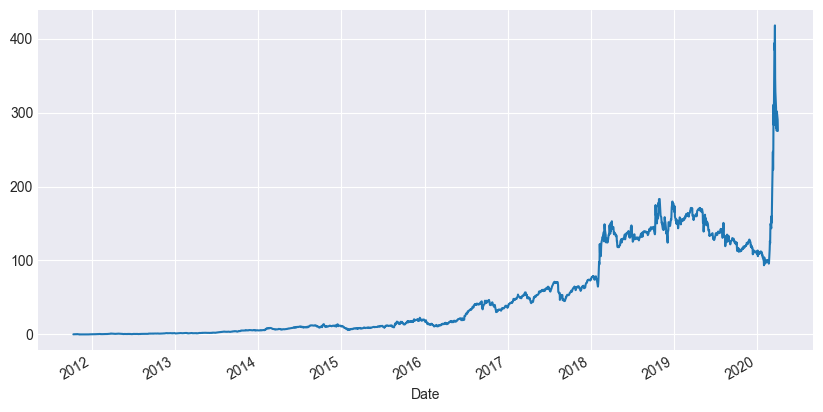

In [15]:
lsv["portfolio_cumulative_returns"].plot(figsize=(10,5))